# Multi-components flux points


In [1]:
%matplotlib inline

In [2]:
import os
import numpy as np
from time import time
from scipy.stats import chi2
from scipy.interpolate import interp1d
from itertools import combinations
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.table import Table
from astropy.coordinates import SkyCoord
from gammapy.irf import load_cta_irfs
from gammapy.maps import Map, WcsGeom, MapAxis
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    ExpCutoffPowerLawSpectralModel,
    PointSpatialModel,
    GaussianSpatialModel,
    SkyModel,
    BackgroundModel,
    Models
)
from gammapy.makers import MapDatasetMaker, SafeMaskMaker
from gammapy.modeling import Fit
from gammapy.estimators import FluxPoints, FluxPointsEstimator
from gammapy.data import Observation
from gammapy.datasets import MapDataset, Datasets
from gammapy.visualization.utils import plot_contour_line

def make_contours(parameters, names, fit, result, npoints, sigmas):
    cts_sigma = []
    for sigma in sigmas:
        contours = dict()
        for par_1, par_2 in combinations(range(len(parameters)), r=2):
            contour = fit.minos_contour(
                parameters[par_1],
                parameters[par_2],
                numpoints=npoints,
                sigma=sigma,
            )
            contours[f"contour_{names[par_1]}_{names[par_2]}"] = {
                names[par_1]: contour["x"].tolist(),
                names[par_2]: contour["y"].tolist(),
            }
        cts_sigma.append(contours)
    return cts_sigma

defcol=[u'#1f77b4',
 u'#ff7f0e',
 u'#2ca02c',
 u'#d62728',
 u'#9467bd',
 u'#8c564b',
 u'#e377c2',
 u'#7f7f7f',
 u'#bcbd22',
 u'#17becf',
 'k']

zero_time = time()

## Simulation

Re-use simulation notebook to set-up test dataset

In [3]:
# Loading IRFs
irfs = load_cta_irfs(
    "$GAMMAPY_DATA/cta-1dc/caldb/data/cta/1dc/bcf/South_z20_50h/irf_file.fits"
)

Ïnvalid unit found in background table! Assuming (s-1 MeV-1 sr-1)


In [4]:
# Define the observation parameters (typically the observation duration and the pointing position):
livetime = 2.0 * u.hr
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")

In [5]:
# Define map geometry for binned simulation
energy_reco = MapAxis.from_edges(
    np.logspace(-1.0, 1.6, 26), unit="TeV", name="energy", interp="log"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(5, 5),
    frame="galactic",
    axes=[energy_reco],
)
# It is usually useful to have a separate binning for the true energy axis
energy_true = MapAxis.from_edges(
    np.logspace(-1.5, 1.5, 30), unit="TeV", name="energy", interp="log"
)

In [6]:
# Define sky model to used simulate the data.
# Here we use a Gaussian spatial model and a Power Law spectral model.
spatial_model = GaussianSpatialModel(
    lon_0="-0.6 deg", lat_0="-0.8 deg", sigma="0.3 deg", frame="galactic"
)
spectral_model = PowerLawSpectralModel(
    index=3, amplitude="1e-11 cm-2 s-1 TeV-1", reference="1 TeV"
)
model1 = SkyModel(
    spatial_model=spatial_model,
    spectral_model=spectral_model,
    name="model1",
)

model2 = SkyModel(
    spatial_model=PointSpatialModel(lon_0="0.9 deg", lat_0="0.1 deg", frame="galactic"),
    spectral_model=ExpCutoffPowerLawSpectralModel(amplitude="2e-12 cm-2 s-1 TeV-1"),
    name="model2",
)

model3 = SkyModel(
    spatial_model=PointSpatialModel(lon_0="0. deg", lat_0="0. deg", frame="galactic"),
    spectral_model=ExpCutoffPowerLawSpectralModel(amplitude="4e-12 cm-2 s-1 TeV-1"),
    name="model3",
)
model4 = SkyModel(
    spatial_model=GaussianSpatialModel(lon_0="0. deg", lat_0="0. deg", sigma="0.15 deg", frame="galactic"),
    spectral_model=ExpCutoffPowerLawSpectralModel(amplitude="9e-12 cm-2 s-1 TeV-1"),
    name="model4",
)
models = [model1, model2, model3, model4]

In [7]:
# Create an in-memory observation
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)


In [8]:
# Make the MapDataset
empty = MapDataset.create(geom, name="dataset-simu")
maker = MapDatasetMaker(selection=["exposure", "background", "psf", "edisp"])
maker_safe_mask = SafeMaskMaker(methods=["offset-max"], offset_max=4.0 * u.deg)
dataset = maker.run(empty, obs)
dataset = maker_safe_mask.run(dataset, obs)


In [9]:
# Add the model on the dataset and Poission fluctuate
dataset.models.extend(models)
dataset.fake()

(<Figure size 432x288 with 2 Axes>,
 <matplotlib.colorbar.Colorbar at 0x1c133582b0>)

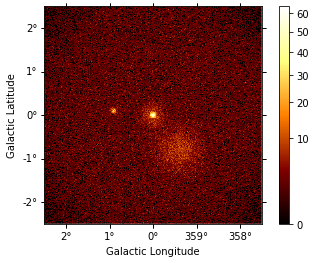

In [10]:
dataset.counts.sum_over_axes().plot(stretch="sqrt", add_cbar=True)

In [11]:
overwrite = False
path=os.getcwd()
prefix="test_FluxPoints"
if overwrite:
    Datasets([dataset]).write(path,prefix=prefix, overwrite=True)
else:
    tag = path+"/"+prefix
    datasets=Datasets.read(tag+"_datasets.yaml",tag+"_models.yaml")
    dataset= datasets[0]
exec_time = time() - zero_time
print("Simulation time in seconds: ",exec_time)

Simulation time in seconds:  4.551750898361206


## Fit


In [12]:
# Make a copy of the dataset
dataset_fit = dataset.copy(name="dataset-fit")
dataset_fit.models["dataset-simu-bkg"].datasets_names = ["dataset-fit"]

#print(dataset_fit.models)

In [13]:
# backgroun model
background_model = dataset_fit.background_model
background_model.parameters["norm"].value = 1.0
background_model.parameters["norm"].frozen = False
background_model.parameters["tilt"].frozen = False

#print(background_model)

In [14]:
re_optimize = False
if re_optimize:
    fit = Fit([dataset_fit])
    result = fit.run(optimize_opts={"print_level": 1})

(<matplotlib.axes._subplots.WCSAxesSubplot at 0x1c13684128>, None)

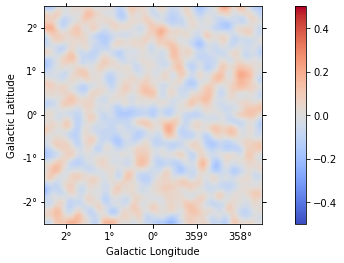

In [15]:
dataset_fit.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)

In [16]:
for m in dataset_fit.models:
    print("\n Model:", m.name)
    print(m.parameters.to_table())


 Model: dataset-simu-bkg
   name     value   unit    min    max frozen   error  
--------- --------- ---- --------- --- ------ ---------
     norm 1.000e+00      0.000e+00 nan  False 0.000e+00
     tilt 0.000e+00            nan nan  False 0.000e+00
reference 1.000e+00  TeV       nan nan   True 0.000e+00

 Model: model1
   name     value         unit         min        max    frozen   error  
--------- ---------- -------------- ---------- --------- ------ ---------
    index  3.000e+00                       nan       nan   True 0.000e+00
amplitude  1.000e-11 cm-2 s-1 TeV-1        nan       nan   True 0.000e+00
reference  1.000e+00            TeV        nan       nan   True 0.000e+00
    lon_0 -6.000e-01            deg        nan       nan   True 0.000e+00
    lat_0 -8.000e-01            deg -9.000e+01 9.000e+01   True 0.000e+00
    sigma  3.000e-01            deg  0.000e+00       nan   True 0.000e+00
        e  0.000e+00                 0.000e+00 1.000e+00   True 0.000e+00
      phi  0

### Prepare groups for linked components

In [17]:
def regroup_linked(models):
    # regroud linkded models
    # this is likely improvable, I was is not very inspired
    groups=[]
    modlist=list(models)
    for m in models:
        if isinstance(m, SkyModel):
            try:
                p = m.spectral_model.parameters["amplitude"]
            except:
                continue
        else:
            try:
                p = m.parameters["norm"]
            except:
                continue

        linked = [m]
        others = [_ for _ in modlist if _ != m]
        for other in others:
            if p in other.parameters:
                linked.append(other)
                modlist.remove(other)
        if len(linked)>1:
            groups.append(linked)
    
    
    ingroup={}
    for m in models:
        num = None
        for kg, g in enumerate(groups):
            if m in g:
                num = kg
                break
        ingroup[m.name]=num
    return groups, ingroup

In [18]:
# try this for linked components test
#dataset.models[model1.name].spectral_model.amplitude = dataset.models[model2.name].spectral_model.amplitude
keep_links = True
groups,ingroup = regroup_linked(dataset_fit.models)
print(ingroup)

{'dataset-simu-bkg': None, 'model1': None, 'model2': None, 'model3': None, 'model4': None}


## Flux points
The idea is to pre-compute everything and rescale only the norm for selected components in each energy band

In [19]:
start_time = time()

In [20]:
# prepare model
dataset = dataset_fit
fp_dataset = dataset_fit.copy(name="fp_estimator")
components=["model3", "model4"]#, "dataset-simu-bkg"
#components=["model1", "model2"]# try this for linked components test

fp_models=[]
skip=[]
npred_frozen = Map.from_geom(fp_dataset._geom, dtype=float)
for name, ev in fp_dataset.evaluators.items():
    npred = Map.from_geom(fp_dataset._geom, dtype=float)
    npred.stack(ev.compute_npred())
    if name in components and name not in skip:
        if keep_links and ingroup[name] is not None:
            for mg in groups[ingroup[name]]:
                if mg.name != name:
                    mg_npred = fp_dataset.evaluators[mg.name].compute_npred()
                    npred.stack(mg_npred)
                    skip.append(mg.name)
        fp_models.append(BackgroundModel(npred, name=name, datasets_names = fp_dataset.name)) 
    elif name not in skip:
        npred_frozen.stack(npred)
bkg = BackgroundModel(npred_frozen, name="frozen", datasets_names = fp_dataset.name)
bkg.norm.frozen = True
fp_models.append(bkg)
fp_dataset.models = Models(fp_models)


In [21]:
# define e_edges
El = dataset._geom.axes[0].edges
Ec = dataset._geom.axes[0].center
e_coords = dataset._geom.get_coord()["energy"]
ebands = range(0,len(El),5)
e_edges = El[ebands]
ne= len(e_edges)
print("edges", e_edges)

e_centers= (e_edges[:-1]*e_edges[1:])**0.5
print("centers", e_centers)

fp_results=dict(e_edges=e_edges,e_centers=e_centers, models={})
for m in fp_models:
    fp_results["models"][m.name] = dict(npred=[], npred_err=[], flux=[], flux_err=[], dnde=[],dnde_err=[])

edges [ 0.1         0.33113113  1.09647822  3.6307806  12.02264373 39.81071719] TeV
centers [ 0.18197009  0.6025596   1.99526235  6.60693435 21.87761572] TeV


In [22]:
# prepare some lists for confidence contours
get_confidence = True
if get_confidence:
    confidence = []
    parameters = [m.norm for m in fp_dataset.models if m.name!="frozen"]
    names = [m.name+".norm" for m in fp_dataset.models if m.name!="frozen"]
    


 	 Energy range 0.10 - 0.33 TeV 
component value error
model3 0.8551733094669991 0.18379352593381845
model4 1.0077110591412404 0.1650235262606849

 	 Energy range 0.33 - 1.10 TeV 
component value error
model3 0.9120624422261543 0.07428431026121798
model4 0.9663485674268939 0.05582315955574743

 	 Energy range 1.10 - 3.63 TeV 
component value error
model3 0.9452763334598056 0.06325121744856689
model4 1.047639956904137 0.04257521824628991

 	 Energy range 3.63 - 12.02 TeV 
component value error
model3 0.9256286658079835 0.07306798857624804
model4 1.014041885844137 0.04810185902080842

 	 Energy range 12.02 - 39.81 TeV 
component value error
model3 1.2546638390671507 0.25544827930598785
model4 0.9810781607177332 0.14783011555978956

 Flux points time in seconds:  24.997634172439575


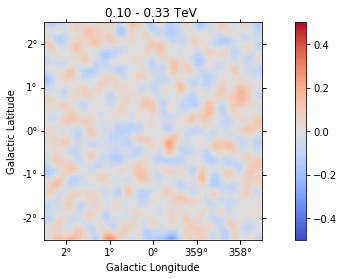

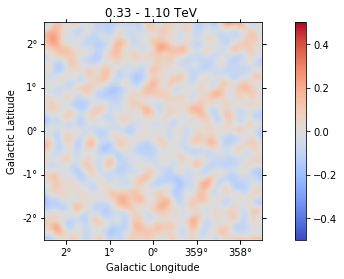

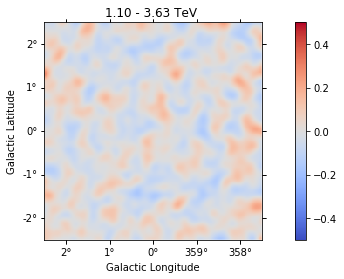

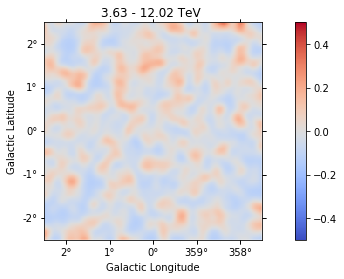

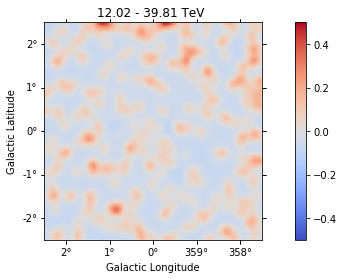

In [23]:
# get flux points
for ke in range(ne-1) :
    e_range = f"{e_edges[ke].value:.2f} - {e_edges[ke+1-ne]:.2f} "
    print("\n \t Energy range", e_range)
    
    # fit flux points
    fp_dataset.mask_fit = Map.from_geom(dataset._geom, data=fp_dataset.exposure.data>0)
    fp_dataset.mask_fit.data &= (e_coords >= e_edges[ke]) & (e_coords <= e_edges[ke+1-ne]) 
    fit = Fit(fp_dataset)
    opti_results = fit.run()
    
    fp_dataset.plot_residuals(method="diff/sqrt(model)", vmin=-0.5, vmax=0.5)
    plt.title(e_range)
    
    print("component", "value", "error")
    for name in components:    
        print(name, fp_dataset.models[name].norm.value,fp_dataset.models[name].norm.error)
            
    # confidence contours
    if get_confidence:
        confidence.append(make_contours(parameters, names, fit, opti_results, npoints=10, sigmas=[1]))

    #transform to spectral points in npred/flux/dnde
    for m in fp_models:
        rel_err = m.norm.error/m.norm.value
    
        npred = Map.from_geom(fp_dataset._geom, dtype=float)
        npred.stack(m.evaluate())
        npred_band = np.nansum(npred.data*fp_dataset.mask_fit.data)

        flux = npred/fp_dataset.exposure.quantity.to("cm2 s")
        flux.data[~np.isfinite(flux.data)]=np.nan
        flux_band = np.nansum(flux.data*fp_dataset.mask_fit.data)*flux.unit
        
        # need a narrow energy binning to do that
        mask = fp_dataset.mask_fit.data[ke:ke+1-ne,:,:].sum(axis=0).astype(bool)
        flux_spec = np.nansum(flux*mask,axis=(1,2)) #apply only the 2d mask of this e_range
        dnde_spec = np.gradient(np.cumsum(flux_spec),El[1:].value)
        udnde = flux.unit/El.unit
        interp = interp1d(np.log10(El[1:].value), np.log10(dnde_spec), kind="linear", fill_value="extrapolate")
        dnde_band =  10**interp(np.log10(e_centers[ke].to(El.unit).value))*udnde
   
        fp_results["models"][m.name]["npred"].append(npred_band)
        fp_results["models"][m.name]["npred_err"].append(rel_err*npred_band)
        fp_results["models"][m.name]["flux"].append(flux_band)
        fp_results["models"][m.name]["flux_err"].append(rel_err*flux_band)
        fp_results["models"][m.name]["dnde"].append(dnde_band)
        fp_results["models"][m.name]["dnde_err"].append(rel_err*dnde_band)

#list of quantities to quantity
for m in fp_models:
    fp_results["models"][m.name]["flux"]=u.quantity.Quantity(fp_results["models"][m.name]["flux"])
    fp_results["models"][m.name]["dnde"]=u.quantity.Quantity(fp_results["models"][m.name]["dnde"])
    fp_results["models"][m.name]["flux_err"]=u.quantity.Quantity(fp_results["models"][m.name]["flux_err"])
    fp_results["models"][m.name]["dnde_err"]=u.quantity.Quantity(fp_results["models"][m.name]["dnde_err"])

exec_time = time() - start_time
print("\n Flux points time in seconds: ",exec_time)

# Confidence contours

Evaluate cross-talk between the different model componets in each energy band.

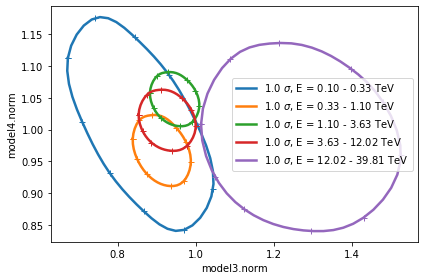

In [24]:
if get_confidence:
    linestyle = ["-", "--", ":"]
    sigma=[1]
    for par_1, par_2 in combinations(range(len(names)), r=2):
        plt.figure()
        for ke in range(ne-1) :
            cts_sigma = confidence[ke]
            e_range = f"{e_edges[ke].value:.2f} - {e_edges[ke+1-ne]:.2f} "
            ax = plt.gca()
            xlabel = names[par_1]
            ylabel = names[par_2]
            for ks in range(len(cts_sigma)):
                tag=f"contour_{names[par_1]}_{names[par_2]}"
                plot_contour_line(
                    ax,
                    cts_sigma[ks][tag][names[par_1]],
                    cts_sigma[ks][tag][names[par_2]],
                    lw=2.5,
                    ls=linestyle[ks],
                    color=defcol[ke],
                    label=f"{sigma[ks]:.1f}" + r" $\sigma$, E = " + e_range,
                )
            ax.set_xlabel(xlabel)
            ax.set_ylabel(ylabel)
            plt.legend()
        plt.tight_layout()

## Re-compute covariance

In that case we can compute the covariance matrix and get error without Minuit. So the fit can be done with any optimizers, which could be usefull when Minuit fails for obscure reasons.

In [25]:
# get covariance
Npred_ini = []
for m in fp_dataset.models:
    Npred = Map.from_geom(fp_dataset._geom, dtype=float)
    Npred.stack(m.map)
    mask = float(m.norm.frozen==False)*fp_dataset.mask_fit.data.astype(float)
    Npred_ini.append(mask * Npred.data)
    
Npred_tot = fp_dataset.npred().data
NoNp2= fp_dataset.counts.data/Npred_tot**2.*fp_dataset.mask_fit.data
dimfit=len(fp_dataset.models)
Hmat = np.zeros((dimfit,dimfit))
for ifit in range(dimfit):
    Hmat[ifit,ifit] = np.sum(NoNp2 * Npred_ini[ifit]**2)
    for jfit in range(ifit+1, dimfit):
        Hmat[ifit,jfit] = np.sum(NoNp2 * Npred_ini[ifit] * Npred_ini[jfit])
        Hmat[jfit,ifit] = Hmat[ifit,jfit]
Hmat = abs(Hmat)/2
print(Hmat)


[[ 7.86890186  2.21155288  0.        ]
 [ 2.21155288 23.49585882  0.        ]
 [ 0.          0.          0.        ]]


In [26]:
# get errors
val, vec = np.linalg.eig(Hmat)
aux=vec**2/val[None,:]
aux[vec==0]=0

dof=1
sigma = [ 1., 2., 3., 4., 5., 8. ]
conf_int = [ chi2.cdf( s**2,1) for s in sigma ]
chi_squared = [ chi2.ppf( ci, dof) for ci in conf_int ]
dLnL1sig = chi_squared[0] / 2.
err1sig  = np.sqrt(dLnL1sig * np.sum(aux, axis=1))
err1sig[np.logical_not(np.isfinite(err1sig))]=0.


/anaconda3/envs/gpy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/anaconda3/envs/gpy-dev/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [27]:
# compare
errfit=np.array([m.norm.error for m in fp_dataset.models])
print(err1sig)
print(errfit)
print(err1sig[err1sig!=0]/errfit[err1sig!=0])

[0.25547574 0.14784651 0.        ]
[0.25544828 0.14783012 0.        ]
[1.00010751 1.00011089]


In [28]:
exec_time = time() - zero_time
print("Total time in seconds: ",exec_time)

Total time in seconds:  33.016453981399536


# Comparison with FluxPointsEstimator

FluxPointsEstimator time in seconds:  155.32651281356812


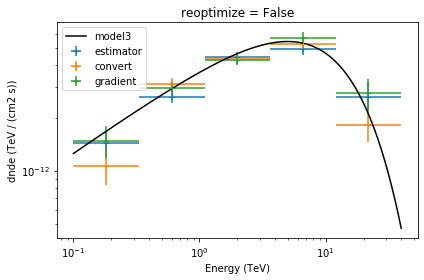

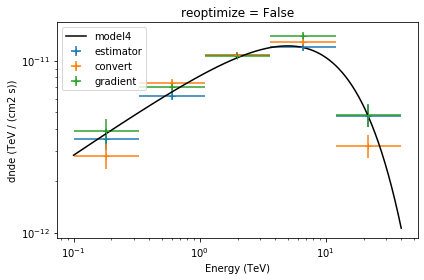

In [29]:
start_time = time()

reoptimize_fp= False # way too long if True
for k, name in enumerate(components):
    plt.figure()
    m=dataset_fit.models[name]
    for mod in dataset_fit.models:
        if mod.name not in components:
            mod.parameters.freeze_all()
    fpe=FluxPointsEstimator(e_edges,source=name, sigma_ul=2, reoptimize=reoptimize_fp)
    fp = fpe.run([dataset_fit])#
    fp.table["is_ul"]=fp.table["ts"]<1
    fp.plot(energy_power=2, energy_unit=u.TeV,flux_unit="cm-2 s-1 TeV-1", color=defcol[0],label="estimator")#
    m.spectral_model.plot(u.Quantity([El[0],El[-1]]), energy_power=2, energy_unit=u.TeV,flux_unit="cm-2 s-1 TeV-1", label=m.name, color="k")#

    # some formatting 
    flux_table=Table()
    flux_table["e_min"] = fp_results["e_edges"][:-1]
    flux_table["e_max"] = fp_results["e_edges"][1:]
    flux_table["flux"] = fp_results["models"][name]["flux"]
    flux_table["flux_err"] = fp_results["models"][name]["flux_err"]
    flux_table.meta['SED_TYPE'] = 'flux'
    fp_flux = FluxPoints(flux_table)
    fp_convert = fp_flux.to_sed_type("dnde", model=m.spectral_model) #to be compared with dndde from gradient
    fp_convert.plot(energy_power=2, energy_unit=u.TeV,flux_unit="cm-2 s-1 TeV-1", color=defcol[1],label="convert")#
    
    dnde_table=Table()
    dnde_table["e_min"] = fp_results["e_edges"][:-1]
    dnde_table["e_max"] = fp_results["e_edges"][1:]
    dnde_table["e_ref"] = fp_results["e_centers"]
    dnde_table["dnde"] = fp_results["models"][name]["dnde"]
    dnde_table["dnde_err"] = fp_results["models"][name]["dnde_err"]
    dnde_table.meta['SED_TYPE'] = 'dnde'
    fp_gradient = FluxPoints(dnde_table)
    fp_gradient.plot(energy_power=2, energy_unit=u.TeV,flux_unit="cm-2 s-1 TeV-1", color=defcol[2],label="gradient")#

    plt.legend()
    plt.title(f"reoptimize = {reoptimize_fp}")
    plt.tight_layout()

exec_time = time() - start_time
print("FluxPointsEstimator time in seconds: ",exec_time)

